# Predictor clouds - Analyse the experiment with complete Lagrangian from exponentiated gradient as grid for grid search

In this, we analyse predictors from expgrad on full dataset, expgrad on partial dataset and hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).


In [1]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML
import statistics 

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tempeh.configurations import datasets

compas_dataset = datasets['compas']()
X_train_all, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train_all, y_test = compas_dataset.get_y(format=pd.Series)
A_train_all, A_test = compas_dataset.get_sensitive_features('race', format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Subsampling process
fractions = [0.005, 0.1, 0.25]
eps = 0.05

In [3]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(solver='liblinear')

In [4]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

import matplotlib.pyplot as plt

In [5]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_vio_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_vio_unmitigated, log_error_unmitigated))

Logistic Regression - Violation: 0.15129907254478464, Error: 0.33455882352941174


In [6]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)

# Overall prediction value
def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
vio_expgrad_all = disparity_moment.gamma(Qexp_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all = error.gamma(Qexp_all)[0]

print('Exponentiated gradient on full dataset : Violation: {}; Errror: {}'.format(
    vio_expgrad_all, error_expgrad_all))

Exponentiated gradient on full dataset : Violation: 0.05000000000000043; Errror: 0.391800773607157


In [7]:
predictors = expgrad_X_logistic._predictors

# Saving all predictors from exp grad all
log_error_expgrad_all = []
log_vio_expgrad_all = []

for i in predictors:
    def Qlog(X): return i.predict(X)
    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    e = error.gamma(Qlog)[0]
    log_error_expgrad_all.append(e)

    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    v = disparity_moment.gamma(Qlog).max()
    log_vio_expgrad_all.append(v)

In [8]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

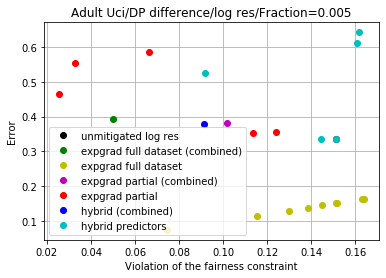

Model				Violation	Error
unmitigated log res		0.1513		0.33456

expgrad full dataset (combined)	0.05		0.3918
expgrad full dataset0		0.1513		0.1513
expgrad full dataset1		0.14469		0.14469
expgrad full dataset2		0.16301		0.16301
expgrad full dataset3		0.1386		0.1386
expgrad full dataset4		0.07441		0.07441
expgrad full dataset5		0.11519		0.11519
expgrad full dataset6		0.15168		0.15168
expgrad full dataset7		0.16373		0.16373
expgrad full dataset8		0.13007		0.13007

expgrad partial (combined)	0.10185		0.3814
expgrad partial dataset0	0.11341		0.35209
expgrad partial dataset1	0.0663		0.58569
expgrad partial dataset2	0.02565		0.46578
expgrad partial dataset3	0.12397		0.3569
expgrad partial dataset4	0.03295		0.5526

hybrid (combined)		0.09136		0.37776
expgrad full dataset0		0.1513		0.33456
expgrad full dataset1		0.16142		0.64225
expgrad full dataset2		0.09192		0.5246
expgrad full dataset3		0.14457		0.33512
expgrad full dataset4		0.16092		0.61199


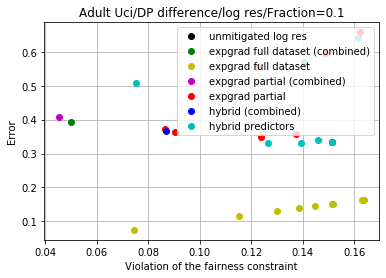

Model				Violation	Error
unmitigated log res		0.1513		0.33456

expgrad full dataset (combined)	0.05		0.3918
expgrad full dataset0		0.1513		0.1513
expgrad full dataset1		0.14469		0.14469
expgrad full dataset2		0.16301		0.16301
expgrad full dataset3		0.1386		0.1386
expgrad full dataset4		0.07441		0.07441
expgrad full dataset5		0.11519		0.11519
expgrad full dataset6		0.15168		0.15168
expgrad full dataset7		0.16373		0.16373
expgrad full dataset8		0.13007		0.13007

expgrad partial (combined)	0.04553		0.40869
expgrad partial dataset0	0.13727		0.35775
expgrad partial dataset1	0.12398		0.34898
expgrad partial dataset2	0.16214		0.65809
expgrad partial dataset3	0.09038		0.3634
expgrad partial dataset4	0.12226		0.55684
expgrad partial dataset5	0.08658		0.37245
expgrad partial dataset6	0.14891		0.59813

hybrid (combined)		0.08678		0.36574
expgrad full dataset0		0.1513		0.33456
expgrad full dataset1		0.14608		0.3405
expgrad full dataset2		0.16142		0.64225
expgrad full dataset3		0.13953		0.33173
exp

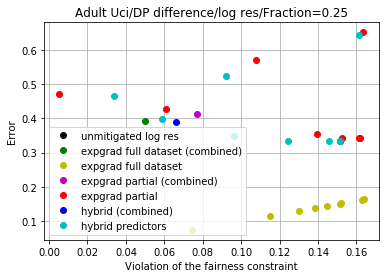

Model				Violation	Error
unmitigated log res		0.1513		0.33456

expgrad full dataset (combined)	0.05		0.3918
expgrad full dataset0		0.1513		0.1513
expgrad full dataset1		0.14469		0.14469
expgrad full dataset2		0.16301		0.16301
expgrad full dataset3		0.1386		0.1386
expgrad full dataset4		0.07441		0.07441
expgrad full dataset5		0.11519		0.11519
expgrad full dataset6		0.15168		0.15168
expgrad full dataset7		0.16373		0.16373
expgrad full dataset8		0.13007		0.13007

expgrad partial (combined)	0.07682		0.41312
expgrad partial dataset0	0.16194		0.34304
expgrad partial dataset1	0.16127		0.34304
expgrad partial dataset2	0.16314		0.65158
expgrad partial dataset3	0.00535		0.47115
expgrad partial dataset4	0.13965		0.3552
expgrad partial dataset5	0.06081		0.42788
expgrad partial dataset6	0.10775		0.56957
expgrad partial dataset7	0.15248		0.34417

hybrid (combined)		0.06623		0.38938
expgrad full dataset0		0.1513		0.33456
expgrad full dataset1		0.14544		0.33399
expgrad full dataset2		0.16142		0.64225


In [9]:
# hybrid model

# Iterations on difference fractions
for i,f in enumerate(fractions):
    log_error_expgrad_fracs = []
    log_error_hybrids = []
    log_vio_expgrad_fracs = []
    log_vio_hybrids = []
    # get samples
    subsampling = train_all.sample(frac=f)
    subsampling = subsampling.reset_index()
    subsampling = subsampling.drop(columns=['index'])
    tmp = subsampling.iloc[:, :-1]
    A_train = subsampling.iloc[:, -1]
    X_train = tmp.iloc[:, :-1]
    y_train = tmp.iloc[:,-1]
    # Expgrad on sub dataset
    expgrad_X_logistic_frac = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True),
        constraints=DemographicParity(), eps=eps, nu=1e-6)

    expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
    
    # Overall output of exp grad on partial
    def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all,
                               sensitive_features=A_train_all)
    vio_expgrad_frac = disparity_moment.gamma(Qexp).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all,
                    sensitive_features=A_train_all)
    error_expgrad_frac = error.gamma(Qexp)[0]

    # Per predictor output
    exp_predictors = expgrad_X_logistic_frac._predictors
    for i in exp_predictors:
        def Qlog(X): return i.predict(X)
        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        e = error.gamma(Qlog)[0]
        log_error_expgrad_fracs.append(e)
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        v = disparity_moment.gamma(Qlog).max()
        log_vio_expgrad_fracs.append(v)

    _wts_log = expgrad_X_logistic_frac._weights


    # Grid Search part
    lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
    grid_search_logistic_frac = GridSearch(
        LogisticRegression(solver='liblinear', fit_intercept=True),
        constraints=DemographicParity(), grid=lambda_vecs_logistic)
    grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                  sensitive_features=A_train_all)
    
    grid_predictors = grid_search_logistic_frac._predictors
    # Overall prediction output
    def Qgrid(X): return _pmf_predict(X, grid_predictors, _wts_log)[:,1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all,
                               sensitive_features=A_train_all)
    vio_hybrid = disparity_moment.gamma(Qgrid).max()

    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all,
                    sensitive_features=A_train_all)
    error_hybrid = error.gamma(Qgrid)['all']

    for i in grid_predictors:
        def Qlog(X): return i.predict(X)
        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        e = error.gamma(Qlog)[0]
        log_error_hybrids.append(e)
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        v = disparity_moment.gamma(Qlog).max()
        log_vio_hybrids.append(v)

    # Plot the predictors
    plt.plot(log_vio_unmitigated, log_error_unmitigated,'ko',label="unmitigated log res")
    plt.plot(vio_expgrad_all, error_expgrad_all,'go',label="expgrad full dataset (combined)")
    plt.plot(log_vio_expgrad_all, log_vio_expgrad_all, 'yo', label="expgrad full dataset")

    plt.plot(vio_expgrad_frac, error_expgrad_frac, 'mo', label="expgrad partial (combined)")
    plt.plot(log_vio_expgrad_fracs, log_error_expgrad_fracs, 'ro', label="expgrad partial")

    plt.plot(vio_hybrid, error_hybrid,'bo',label="hybrid (combined)")
    plt.plot(log_vio_hybrids, log_error_hybrids,'co',label="hybrid predictors")

    plt.xlabel('Violation of the fairness constraint')
    plt.ylabel('Error')
    plt.title('Adult Uci/DP difference/log res/Fraction={}'.format(f))
    plt.legend()
    plt.grid()
    plt.show()
    
    print('{}\t\t\t\t{}\t{}'.format('Model', 'Violation', 'Error'))
    print('{}\t\t{}\t\t{}'.format('unmitigated log res', round(log_vio_unmitigated,5), round(log_error_unmitigated,5)))
    print('')
    print('{}\t{}\t\t{}'.format('expgrad full dataset (combined)', round(vio_expgrad_all,5), round(error_expgrad_all,5)))
    for i in range(len(log_vio_expgrad_all)):
        print('{}{}\t\t{}\t\t{}'.format('expgrad full dataset', i, round(log_vio_expgrad_all[i],5), 
                                      round(log_vio_expgrad_all[i],5)))

    print('')
    print('{}\t{}\t\t{}'.format('expgrad partial (combined)', round(vio_expgrad_frac,5), round(error_expgrad_frac,5)))
    for i in range(len(log_vio_expgrad_fracs)):
        print('{}{}\t{}\t\t{}'.format('expgrad partial dataset', i, round(log_vio_expgrad_fracs[i],5), 
                                    round(log_error_expgrad_fracs[i],5)))

    print('')
    print('{}\t\t{}\t\t{}'.format('hybrid (combined)', round(vio_hybrid,5), round(error_hybrid,5)))
    for i in range(len(log_vio_hybrids)):
        print('{}{}\t\t{}\t\t{}'.format('expgrad full dataset', i, round(log_vio_hybrids[i],5), round(log_error_hybrids[i],5)))


    